Setup, paths, safe display, quick helpers

In [17]:
# =========================
# 1) Setup, paths, helpers
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# metrics
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error
)

# pretty display works in notebooks; falls back to print elsewhere
try:
    from IPython.display import display
except Exception:
    def display(x): print(x)

# paths
PROC = Path("./processed"); PROC.mkdir(exist_ok=True)
FEAT_PARQ = PROC / "quarterly_features.parquet"
FEAT_CSV  = PROC / "quarterly_features_clean.csv"

def smape(y_true, y_pred):
    """
    Symmetric MAPE in percent.
    """
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred))
    denom[denom == 0] = 1.0
    return 100.0 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)

def pick(cols, candidates):
    """
    Return first matching column name (exact or substring) from `cols`.
    """
    cols_l = [c.lower() for c in cols]
    for name in candidates:
        if name in cols:
            return name
    for name in candidates:
        for c, cl in zip(cols, cols_l):
            if name.lower() in cl:
                return c
    return None

Load features with a clean quarter index

In [18]:
# =========================
# 2) Load quarterly features
# =========================
def load_qdf():
    if FEAT_PARQ.exists():
        try:
            df = pd.read_parquet(FEAT_PARQ)
        except Exception:
            df = None
    else:
        df = None

    if df is None:
        # fall back to CSV
        if FEAT_CSV.exists():
            df = pd.read_csv(FEAT_CSV, index_col=0, parse_dates=True)
        else:
            # final fallback: raw export (if clean file not present)
            raw_csv = PROC / "quarterly_features.csv"
            if not raw_csv.exists():
                raise FileNotFoundError("No quarterly features found in ./processed/")
            df = pd.read_csv(raw_csv, index_col=0, parse_dates=True)

    if not isinstance(df.index, pd.DatetimeIndex):
        # try to coerce
        df.index = pd.to_datetime(df.index, errors="coerce")
    df.index.name = "date_q"
    df = df.sort_index()
    return df

qdf = load_qdf()
print(f"Loaded qdf: shape={qdf.shape} | {qdf.index.min().date()} → {qdf.index.max().date()}")
display(qdf.head(3))

Loaded qdf: shape=(43, 13) | 2014-09-30 → 2025-03-31


excess_ret  midcap_qret  nifty_qret  rain_anom   cpi_yoy  \
date_q                                                                 
2014-09-30   -0.017474     0.028963    0.046437  -7.449626  6.681568   
2014-12-31    0.062164     0.102077    0.039913  -7.449626  4.054538   
2015-03-31    0.008021     0.033169    0.025149  -7.449626  5.272440   

             gdp_yoy  repo_chg_bps  ret_prev_q  rain_anom_lag  cpi_yoy_lag  \
date_q                                                                       
2014-09-30  8.704109           0.0    0.288472      69.879102     7.859486   
2014-12-31  5.922736           0.0    0.028963      -7.449626     6.681568   
2015-03-31  7.112080         -50.0    0.102077      -7.449626     4.054538   

            gdp_yoy_lag  repo_chg_lag  excess_next_q  
date_q                                                
2014-09-30     8.023963           0.0       0.062164  
2014-12-31     8.704109           0.0       0.008021  
2015-03-31     5.922736           0.0       0.015073

Build y and X (baseline & enriched), strict masking

In [19]:
# =========================
# 3) Targets & designs
# =========================
required_cols = [
    "excess_next_q","ret_prev_q",
    "rain_anom_lag","gdp_yoy_lag","cpi_yoy_lag","repo_chg_lag"
]
missing = [c for c in required_cols if c not in qdf.columns]
if missing:
    raise KeyError(f"Missing expected columns: {missing}")

y = pd.to_numeric(qdf["excess_next_q"], errors="coerce")

X_base = qdf[["ret_prev_q"]].apply(pd.to_numeric, errors="coerce")
X_en   = qdf[["ret_prev_q","rain_anom_lag","gdp_yoy_lag","cpi_yoy_lag","repo_chg_lag"]]
X_en   = X_en.apply(pd.to_numeric, errors="coerce")

# strict mask (finite)
mask = X_en.replace([np.inf, -np.inf], np.nan).notna().all(axis=1) & y.replace([np.inf,-np.inf],np.nan).notna()
X_base, X_en, y = X_base.loc[mask], X_en.loc[mask], y.loc[mask]

assert X_base.index.equals(y.index) and X_en.index.equals(y.index)
print(f"Data (post-mask): y={y.shape}, X_base={X_base.shape}, X_en={X_en.shape}")

Data (post-mask): y=(43,), X_base=(43, 1), X_en=(43, 5)


Model factories (ElasticNet baseline & LightGBM/GBR)

In [20]:
# =========================
# 4) Model factories
# =========================
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV

def make_baseline():
    return Pipeline([
        ("sc", StandardScaler(with_mean=True, with_std=True)),
        ("enet", ElasticNetCV(
            cv=3, l1_ratio=[0.1,0.3,0.5,0.7,0.9],
            alphas=np.logspace(-3, 1, 80),
            max_iter=10000, tol=1e-4, random_state=42
        ))
    ])

def make_lgbm():
    try:
        from lightgbm import LGBMRegressor
        return LGBMRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=3,
            subsample=0.9, colsample_bytree=0.9,
            min_child_samples=10, random_state=42, n_jobs=-1
        )
    except Exception:
        from sklearn.ensemble import GradientBoostingRegressor
        return GradientBoostingRegressor(
            n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42
        )

Expanding-window splitter & CV evaluator

In [21]:
# =========================
# 5) Expanding splits & CV eval
# =========================
def make_expanding_splits(n, min_train=24, test_size=2, step=1):
    """
    Expanding-window CV.
    train = [0, start), test = [start, start+test_size)
    """
    splits, start = [], min_train
    while start + test_size <= n:
        tr = np.arange(0, start, dtype=int)
        te = np.arange(start, start + test_size, dtype=int)
        splits.append((tr, te))
        start += step
    return splits

def cv_eval(model_factory, X, y, splits):
    maes, rmses, r2s, das, maps, smapes = [], [], [], [], [], []
    for tr, te in splits:
        Xtr, ytr = X.iloc[tr], y.iloc[tr]
        Xte, yte = X.iloc[te], y.iloc[te]

        model = model_factory()
        model.fit(Xtr, ytr)
        yhat = model.predict(Xte)

        maes.append(mean_absolute_error(yte, yhat))
        rmses.append(mean_squared_error(yte, yhat, squared=False))
        r2s.append(r2_score(yte, yhat))
        das.append(np.mean(np.sign(yhat) == np.sign(yte)))
        maps.append(mean_absolute_percentage_error(yte, yhat))
        smapes.append(smape(yte, yhat))

    return {
        "MAE":  float(np.mean(maes)),
        "RMSE": float(np.mean(rmses)),
        "R2":   float(np.mean(r2s)),
        "DA":   float(np.mean(das)),     # aka HitRate
        "MAPE": float(np.mean(maps)),
        "SMAPE%": float(np.mean(smapes)),
        "Folds": len(splits),
    }

RQ1 — Baseline vs Enriched (CV)

In [22]:
# =========================
# 6) RQ1: baseline vs enriched
# =========================
splits = make_expanding_splits(len(y), min_train=24, test_size=2, step=1)
if len(splits) == 0:
    raise ValueError("No CV splits — reduce min_train/test_size or increase data length.")

m_base = cv_eval(make_baseline, X_base, y, splits)
m_en   = cv_eval(make_lgbm,   X_en,   y, splits)

rq1_tbl = pd.DataFrame([m_base, m_en], index=["Baseline(ret_prev_q)", "Enriched(LightGBM)"])

# deltas vs baseline for numeric cols
num_cols = rq1_tbl.select_dtypes(include=[float, int]).columns
delta = rq1_tbl[num_cols].subtract(rq1_tbl.loc["Baseline(ret_prev_q)", num_cols], axis="columns")
delta = delta.rename(columns=lambda c: f"Δ{c}")
rq1_out = pd.concat([rq1_tbl, delta], axis=1)

display(rq1_out)
rq1_out.to_csv(PROC/"rq1_metrics.csv")
print("Saved:", (PROC/"rq1_metrics.csv").resolve())

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 33, number of used features: 5
[LightGBM] [Info] Start training from score 0.008581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

MAE      RMSE        R2        DA      MAPE  \
Baseline(ret_prev_q)  0.043413  0.049416  -7.84902  0.694444  1.053408   
Enriched(LightGBM)    0.054651  0.061580 -13.16877  0.472222  2.894057   

                          SMAPE%  Folds      ΔMAE     ΔRMSE       ΔR2  \
Baseline(ret_prev_q)  139.239433     18  0.000000  0.000000  0.000000   
Enriched(LightGBM)    130.542415     18  0.011238  0.012165 -5.319749   

                           ΔDA     ΔMAPE   ΔSMAPE%  ΔFolds  
Baseline(ret_prev_q)  0.000000  0.000000  0.000000     0.0  
Enriched(LightGBM)   -0.222222  1.840649 -8.697019     0.0

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_metrics.csv


GDP proxy from rain (global fit for inspection)

In [23]:
# =========================
# 7) GDP proxy from rain (global fit — inspection)
# =========================
import statsmodels.api as sm

if "rain_anom" not in qdf.columns or "gdp_yoy" not in qdf.columns:
    print("[warn] 'rain_anom' or 'gdp_yoy' not found in qdf; skip global proxy fit.")
else:
    tmp = qdf[["rain_anom","gdp_yoy"]].copy()
    tmp["gdp_yoy_tplus1"] = tmp["gdp_yoy"].shift(-1)
    tmp = tmp.dropna()

    Xg = sm.add_constant(tmp[["rain_anom"]])
    ols = sm.OLS(tmp["gdp_yoy_tplus1"], Xg).fit()
    print(ols.summary())

    qdf["gdp_pred_from_rain"] = pd.Series(
        ols.predict(sm.add_constant(qdf[["rain_anom"]])),
        index=qdf.index
    )
    display(qdf[["gdp_yoy","gdp_pred_from_rain"]].tail(6))

                            OLS Regression Results                            
Dep. Variable:         gdp_yoy_tplus1   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.6549
Date:                Sat, 16 Aug 2025   Prob (F-statistic):              0.423
Time:                        12:46:05   Log-Likelihood:                -134.19
No. Observations:                  42   AIC:                             272.4
Df Residuals:                      40   BIC:                             275.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.0173      0.953      6.313      0.0

gdp_yoy  gdp_pred_from_rain
date_q                                  
2023-12-31  9.514555            5.767463
2024-03-31  8.354641            5.767463
2024-06-30  6.511800            5.767463
2024-09-30  5.612025            6.337293
2024-12-31  6.366486            6.337293
2025-03-31  7.384530            6.337293

RQ3 — Enriched vs Enriched + GDP-proxy (fold-safe)

In [24]:
# =========================
# 8) RQ3: add GDP proxy (fold-safe)
# =========================
def _fit_proxy_fold(idx_tr, idx_te, qdf_full):
    """
    Fit on TRAIN only: rain_anom(t) -> gdp_yoy(t+1).
    Drop the last train row so its (t+1) target can't leak into test.
    Return predictions for train and test indices (Series aligned by index).
    """
    # Build training pairs (rain_t, gdp_yoy_{t+1})
    rain_tr_all = pd.to_numeric(qdf_full.loc[idx_tr, "rain_anom"], errors="coerce")
    gdp_next_all = pd.to_numeric(qdf_full.loc[idx_tr, "gdp_yoy"], errors="coerce").shift(-1)

    # Drop the last train row to avoid using a target that belongs to first test quarter
    idx_tr_safe = idx_tr[:-1]
    train_df = pd.DataFrame({
        "rain": rain_tr_all.loc[idx_tr_safe],
        "gdp_next": gdp_next_all.loc[idx_tr_safe]
    }).dropna()

    # If not enough valid rows after cleaning, return NaNs (caller will skip the fold)
    if len(train_df) < 3:
        return (pd.Series(index=idx_tr, dtype=float),
                pd.Series(index=idx_te, dtype=float))

    # --- Fit OLS with an explicit intercept column ---
    X_tr = pd.DataFrame({
        "const": 1.0,
        "rain": train_df["rain"].values
    }, index=train_df.index)
    y_tr = train_df["gdp_next"].values

    ols = sm.OLS(y_tr, X_tr).fit()

    # --- Predict for TRAIN and TEST with the *same* column schema/order ---
    Xtr_pred = pd.DataFrame({
        "const": 1.0,
        "rain": pd.to_numeric(qdf_full.loc[idx_tr, "rain_anom"], errors="coerce").values
    }, index=idx_tr)

    Xte_pred = pd.DataFrame({
        "const": 1.0,
        "rain": pd.to_numeric(qdf_full.loc[idx_te, "rain_anom"], errors="coerce").values
    }, index=idx_te)

    # Ensure exact column order as in the fitted model
    cols = list(ols.params.index)  # e.g., ["const", "rain"]
    Xtr_pred = Xtr_pred.reindex(columns=cols)
    Xte_pred = Xte_pred.reindex(columns=cols)

    # If any NaNs slipped in (shouldn't, but guard anyway), bail on this fold
    if Xtr_pred.isna().any().any() or Xte_pred.isna().any().any():
        return (pd.Series(index=idx_tr, dtype=float),
                pd.Series(index=idx_te, dtype=float))

    pred_tr = pd.Series(ols.predict(Xtr_pred), index=idx_tr, name="gdp_pred")
    pred_te = pd.Series(ols.predict(Xte_pred), index=idx_te, name="gdp_pred")
    return pred_tr, pred_te


def _cv_with_optional_proxy(model_factory, X_en, y, splits, qdf_full, use_proxy: bool):
    maes, rmses, r2s, das = [], [], [], []
    for tr, te in splits:
        idx_tr, idx_te = X_en.index[tr], X_en.index[te]
        Xtr, Xte = X_en.loc[idx_tr].copy(), X_en.loc[idx_te].copy()
        ytr, yte = y.loc[idx_tr], y.loc[idx_te]

        if use_proxy:
            pr_tr, pr_te = _fit_proxy_fold(idx_tr, idx_te, qdf_full)
            if pr_tr.isna().all() or pr_te.isna().all():
                continue
            Xtr = Xtr.assign(gdp_pred=pr_tr)
            Xte = Xte.assign(gdp_pred=pr_te)

        mdl = model_factory()
        mdl.fit(Xtr, ytr)
        yhat = mdl.predict(Xte)

        maes.append(mean_absolute_error(yte, yhat))
        rmses.append(mean_squared_error(yte, yhat, squared=False))
        r2s.append(r2_score(yte, yhat))
        das.append(np.mean(np.sign(yhat) == np.sign(yte)))

    if not maes:
        raise ValueError("No valid folds (insufficient data for proxy).")

    return {"MAE": np.mean(maes), "RMSE": np.mean(rmses), "R2": np.mean(r2s), "DA": np.mean(das), "Folds": len(maes)}

# Align on rows where proxy inputs exist
need = ["rain_anom","gdp_yoy"]
aligned_idx = X_en.index.intersection(qdf.dropna(subset=need).index)
X_cmp, y_cmp = X_en.loc[aligned_idx], y.loc[aligned_idx]

spl = make_expanding_splits(len(y_cmp), min_train=24, test_size=2, step=1)
m_no   = _cv_with_optional_proxy(make_lgbm, X_cmp, y_cmp, spl, qdf_full=qdf, use_proxy=False)
m_plus = _cv_with_optional_proxy(make_lgbm, X_cmp, y_cmp, spl, qdf_full=qdf, use_proxy=True)

rq3_tbl = pd.DataFrame([m_no, m_plus], index=["Enriched(no gdp_pred)", "Enriched(+ gdp_pred)"])
dnum = rq3_tbl.select_dtypes(include=[float, int]).columns
rq3_delta = rq3_tbl[dnum].subtract(rq3_tbl.loc["Enriched(no gdp_pred)", dnum], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq3_out = pd.concat([rq3_tbl, rq3_delta], axis=1)

display(rq3_out)
rq3_out.to_csv(PROC/"rq3_enriched_with_gdp_pred.csv")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Start training from score 0.015467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE      RMSE         R2        DA  Folds  \
Enriched(no gdp_pred)  0.054651  0.061580 -13.168770  0.472222     18   
Enriched(+ gdp_pred)   0.053640  0.060046 -10.504549  0.500000     18   

                           ΔMAE     ΔRMSE       ΔR2       ΔDA  ΔFolds  
Enriched(no gdp_pred)  0.000000  0.000000  0.000000  0.000000     0.0  
Enriched(+ gdp_pred)  -0.001011 -0.001534  2.664221  0.027778     0.0

RQ4 — Interaction (rain × repo) uplift test

In [25]:
# =========================
# 9) RQ4: add interaction rain×repo
# =========================
mask_full = X_en.replace([np.inf,-np.inf], np.nan).notna().all(1) & y.notna()
X_en_masked = X_en.loc[mask_full].sort_index()
y_int       = y.loc[mask_full].sort_index()

spl_int = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)
if len(spl_int) == 0:
    raise ValueError("No CV splits for interaction test.")

X_int = X_en_masked.assign(
    rain_repo_int = X_en_masked["rain_anom_lag"] * X_en_masked["repo_chg_lag"]
).replace([np.inf,-np.inf], np.nan).dropna()

# pair indices
X_cmp = X_en_masked.loc[X_int.index]
y_cmp = y_int.loc[X_int.index]
spl_int = make_expanding_splits(len(y_cmp), min_train=24, test_size=2, step=1)

m_full = cv_eval(make_lgbm, X_cmp, y_cmp, spl_int)
m_int  = cv_eval(make_lgbm, X_int, y_cmp, spl_int)

rq4_tbl   = pd.DataFrame([m_full, m_int], index=["Enriched","Enriched+interaction"])
cols = rq4_tbl.select_dtypes(include=[float, int]).columns
rq4_delta = rq4_tbl[cols].subtract(rq4_tbl.loc["Enriched", cols], axis="columns").rename(columns=lambda c: f"Δ{c}")
rq4_out   = pd.concat([rq4_tbl, rq4_delta], axis=1)

display(rq4_out)
rq4_out.to_csv(PROC/"rq4_interaction_uplift.csv")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 26, number of used features: 5
[LightGBM] [Info] Start training from score 0.007365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49
[LightGBM] [Info] Number of data points in the train set: 31, number of used features: 5
[LightGBM] [Info] Start training from score 0.007704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 51
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 5
[LightGBM] [Info] Start training from score 0.009841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 38, number of used features: 5
[LightGBM] [Info] Start training from score 0.013665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 6
[LightGBM] [Info] Start training from score 0.008164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 40, number of used features: 6
[LightGBM] [Info] Start training from score 0.015187
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE     RMSE         R2        DA      MAPE  \
Enriched              0.054651  0.06158 -13.168770  0.472222  2.894057   
Enriched+interaction  0.054825  0.06047 -12.880665  0.472222  2.790273   

                          SMAPE%  Folds      ΔMAE     ΔRMSE       ΔR2  ΔDA  \
Enriched              130.542415     18  0.000000  0.000000  0.000000  0.0   
Enriched+interaction  137.318395     18  0.000175 -0.001111  0.288105  0.0   

                         ΔMAPE  ΔSMAPE%  ΔFolds  
Enriched              0.000000  0.00000     0.0  
Enriched+interaction -0.103784  6.77598     0.0

Out-of-fold permutation importance

In [26]:
# =========================
# 10) OOF permutation importance
# =========================
from sklearn.inspection import permutation_importance

splits_pi = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)
all_means, all_stds = [], []
for tr, te in splits_pi:
    idx_tr, idx_te = X_en_masked.index[tr], X_en_masked.index[te]
    Xtr, ytr = X_en_masked.loc[idx_tr], y_int.loc[idx_tr]
    Xte, yte = X_en_masked.loc[idx_te], y_int.loc[idx_te]

    mdl = make_lgbm(); mdl.fit(Xtr, ytr)
    pi = permutation_importance(mdl, Xte, yte,
                                scoring="neg_mean_absolute_error",
                                n_repeats=200, random_state=42, n_jobs=-1)
    all_means.append(pd.Series(pi.importances_mean, index=X_en_masked.columns))
    all_stds.append(pd.Series(pi.importances_std,  index=X_en_masked.columns))

imp_mean = pd.concat(all_means, axis=1).mean(axis=1).rename("perm_importance_mean")
imp_std  = pd.concat(all_stds,  axis=1).mean(axis=1).rename("perm_importance_std")
imp_df   = pd.concat([imp_mean, imp_std], axis=1).sort_values("perm_importance_mean", ascending=False)

display(imp_df)
imp_df.to_csv(PROC/"rq4_permutation_importance.csv")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


perm_importance_mean  perm_importance_std
cpi_yoy_lag                0.003147             0.003100
repo_chg_lag              -0.000012             0.000012
ret_prev_q                -0.000183             0.001737
gdp_yoy_lag               -0.000334             0.001010
rain_anom_lag             -0.000931             0.002070

Diagnostics — in-sample & OOF Pred vs Actual; residuals

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 65
[LightGBM] [Info] Number of data points in the train set: 43, number of used features: 5
[LightGBM] [Info] Start training from score 0.014469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


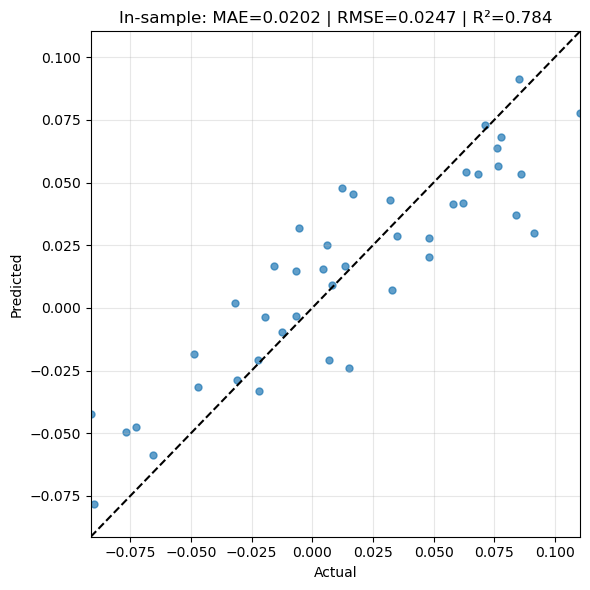

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


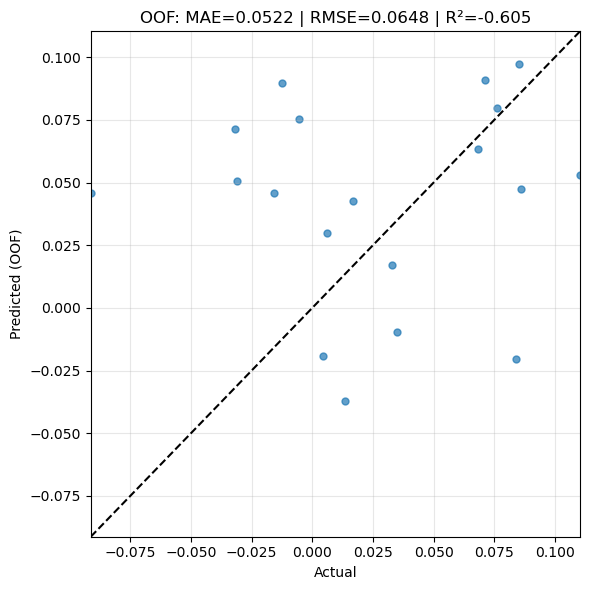

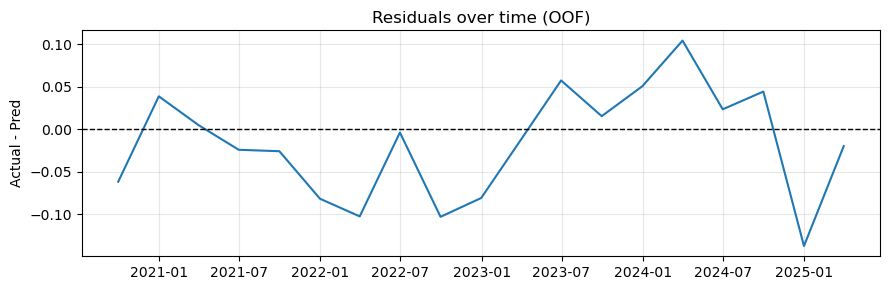

In [27]:
# =========================
# 11) Pred vs Actual & residuals
# =========================
# in-sample
mdl_in = make_lgbm().fit(X_en, y)
y_hat_in = pd.Series(mdl_in.predict(X_en), index=y.index)

mae_in  = mean_absolute_error(y, y_hat_in)
rmse_in = mean_squared_error(y, y_hat_in, squared=False)
r2_in   = r2_score(y, y_hat_in)

plt.figure(figsize=(6,6))
plt.scatter(y, y_hat_in, s=25, alpha=0.7)
lims = [float(min(y.min(), y_hat_in.min())), float(max(y.max(), y_hat_in.max()))]
plt.plot(lims, lims, "--", color="black")
plt.xlim(lims); plt.ylim(lims)
plt.title(f"In-sample: MAE={mae_in:.4f} | RMSE={rmse_in:.4f} | R²={r2_in:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# OOF
splits_oof = make_expanding_splits(len(y), min_train=24, test_size=2, step=1)
oof = pd.Series(index=y.index, dtype=float)
for tr, te in splits_oof:
    idx_tr, idx_te = X_en.index[tr], X_en.index[te]
    mdl = make_lgbm().fit(X_en.loc[idx_tr], y.loc[idx_tr])
    oof.loc[idx_te] = mdl.predict(X_en.loc[idx_te])

oof = oof.dropna(); y_oof = y.loc[oof.index]
mae_oof  = mean_absolute_error(y_oof, oof)
rmse_oof = mean_squared_error(y_oof, oof, squared=False)
r2_oof   = r2_score(y_oof, oof)

plt.figure(figsize=(6,6))
plt.scatter(y_oof, oof, s=25, alpha=0.7)
lims = [float(min(y_oof.min(), oof.min())), float(max(y_oof.max(), oof.max()))]
plt.plot(lims, lims, "--", color="black")
plt.xlim(lims); plt.ylim(lims)
plt.title(f"OOF: MAE={mae_oof:.4f} | RMSE={rmse_oof:.4f} | R²={r2_oof:.3f}")
plt.xlabel("Actual"); plt.ylabel("Predicted (OOF)"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

res_oof = (y_oof - oof)
plt.figure(figsize=(9,3))
plt.plot(res_oof.index, res_oof.values)
plt.axhline(0, ls="--", lw=1, color="black")
plt.title("Residuals over time (OOF)")
plt.ylabel("Actual - Pred"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

RQ2 — Good vs Poor monsoon (thresholded, lagged, effect)

N_good=15 | N_poor=20 | thr=±4.0% | positive_is_good=True
Welch t-test: Δmean(good - poor)=0.0290 | p=0.09705


C:\Users\abpanick\AppData\Local\Temp\ipykernel_29648\90077519.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([good, poor], labels=[lab_g, lab_p], showmeans=True)


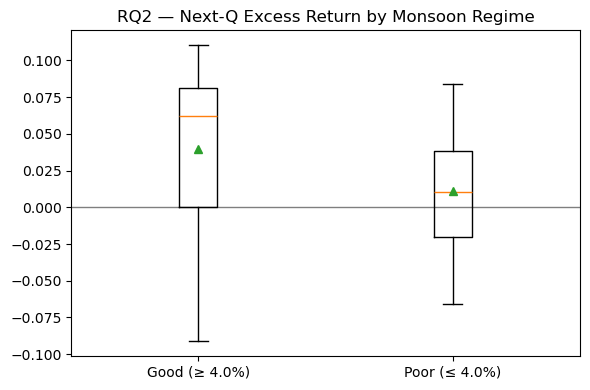

In [28]:
# =========================
# 12) RQ2: good vs poor monsoon
# =========================
from scipy.stats import ttest_ind

if "rain_anom_lag" not in qdf.columns or "excess_next_q" not in qdf.columns:
    print("[warn] Missing rain_anom_lag/excess_next_q in qdf; skipping RQ2.")
else:
    thr = 4.0  # ±4% anomaly threshold
    positive_is_good = True

    anom = pd.to_numeric(qdf["rain_anom_lag"], errors="coerce")
    ynx  = pd.to_numeric(qdf["excess_next_q"], errors="coerce")
    mk   = anom.notna() & ynx.notna()

    if positive_is_good:
        good = ynx[mk & (anom >= +thr)].to_numpy()
        poor = ynx[mk & (anom <= -thr)].to_numpy()
    else:
        good = ynx[mk & (anom <= -thr)].to_numpy()
        poor = ynx[mk & (anom >= +thr)].to_numpy()

    print(f"N_good={len(good)} | N_poor={len(poor)} | thr=±{thr}% | positive_is_good={positive_is_good}")

    if len(good) >= 3 and len(poor) >= 3:
        tstat, pval = ttest_ind(good, poor, equal_var=False)
        print(f"Welch t-test: Δmean(good - poor)={good.mean()-poor.mean():.4f} | p={pval:.4g}")
    else:
        print("Too few samples for a t-test (need ≥3 per group).")

    plt.figure(figsize=(6,4))
    lab_g = f"Good ({'≥' if positive_is_good else '≤'} {thr}%)"
    lab_p = f"Poor ({'≤' if positive_is_good else '≥'} {thr}%)"
    plt.boxplot([good, poor], labels=[lab_g, lab_p], showmeans=True)
    plt.title("RQ2 — Next-Q Excess Return by Monsoon Regime")
    plt.axhline(0, lw=1, color="black", alpha=0.5)
    plt.tight_layout(); plt.show()

RQ3: Enriched vs Enriched + GDP-proxy

In [29]:
# =========================
# 13) RQ3 — GDP proxy (fold-safe) and paired comparison
# =========================
import statsmodels.api as sm

def _fit_proxy_fold(idx_tr, idx_te, qdf_full) -> tuple[pd.Series, pd.Series]:
    """
    Fit OLS on TRAIN only: rain_anom(t) -> gdp_yoy(t+1).
    Drop the last train row so its target doesn't land in test.
    Return predictions for both TRAIN and TEST (Series indexed by dates).
    """
    # Build training pairs
    rain_tr_all = pd.to_numeric(qdf_full.loc[idx_tr, "rain_anom"], errors="coerce")
    gdp_next_all = pd.to_numeric(qdf_full.loc[idx_tr, "gdp_yoy"], errors="coerce").shift(-1)

    # Avoid spillover of the last train row's target into test
    idx_tr_safe = idx_tr[:-1]
    train_df = pd.DataFrame({
        "rain": rain_tr_all.loc[idx_tr_safe],
        "gdp_next": gdp_next_all.loc[idx_tr_safe]
    }).dropna()

    if len(train_df) < 3:
        # Not enough data to fit; return NaNs to skip this fold
        return (pd.Series(index=idx_tr, dtype=float),
                pd.Series(index=idx_te, dtype=float))

    # Explicit [const, rain] design (prevents add_constant mis-detection)
    X_tr = pd.DataFrame({"const": 1.0, "rain": train_df["rain"].values}, index=train_df.index)
    y_tr = train_df["gdp_next"].values
    ols = sm.OLS(y_tr, X_tr).fit()

    # Predict TRAIN/TEST with identical columns & order
    Xtr_pred = pd.DataFrame({
        "const": 1.0,
        "rain": pd.to_numeric(qdf_full.loc[idx_tr, "rain_anom"], errors="coerce").values
    }, index=idx_tr)[["const","rain"]]

    Xte_pred = pd.DataFrame({
        "const": 1.0,
        "rain": pd.to_numeric(qdf_full.loc[idx_te, "rain_anom"], errors="coerce").values
    }, index=idx_te)[["const","rain"]]

    if Xtr_pred.isna().any().any() or Xte_pred.isna().any().any():
        return (pd.Series(index=idx_tr, dtype=float),
                pd.Series(index=idx_te, dtype=float))

    pr_tr = pd.Series(ols.predict(Xtr_pred), index=idx_tr, name="gdp_pred")
    pr_te = pd.Series(ols.predict(Xte_pred), index=idx_te, name="gdp_pred")
    return pr_tr, pr_te

def _cv_with_optional_proxy(model_factory, X_en, y, splits, qdf_full, use_proxy: bool):
    """
    Expanding-window CV. If use_proxy=True, inject a fold-safe GDP proxy feature.
    """
    maes, rmses, r2s, das = [], [], [], []
    for tr_pos, te_pos in splits:
        idx_tr, idx_te = X_en.index[tr_pos], X_en.index[te_pos]
        Xtr, Xte = X_en.loc[idx_tr].copy(), X_en.loc[idx_te].copy()
        ytr, yte = y.loc[idx_tr], y.loc[idx_te]

        if use_proxy:
            pr_tr, pr_te = _fit_proxy_fold(idx_tr, idx_te, qdf_full)
            # If proxy couldn't be computed, skip this fold
            if pr_tr.isna().all() or pr_te.isna().all():
                continue
            Xtr = Xtr.assign(gdp_pred=pr_tr)
            Xte = Xte.assign(gdp_pred=pr_te)

        mdl = model_factory()
        mdl.fit(Xtr, ytr)
        yhat = mdl.predict(Xte)

        maes.append(mean_absolute_error(yte, yhat))
        rmses.append(mean_squared_error(yte, yhat, squared=False))
        r2s.append(r2_score(yte, yhat))
        das.append(np.mean(np.sign(yhat) == np.sign(yte)))

    if not maes:
        raise ValueError("No valid folds — check rain_anom/gdp_yoy coverage or reduce min_train.")

    return {"MAE": np.mean(maes), "RMSE": np.mean(rmses), "R2": np.mean(r2s), "DA": np.mean(das), "Folds": len(maes)}

# Align to rows where proxy inputs exist
need_cols = ["rain_anom", "gdp_yoy"]
aligned_idx = X_en.index.intersection(qdf.dropna(subset=need_cols).index)
X_cmp, y_cmp = X_en.loc[aligned_idx], y.loc[aligned_idx]

spl = make_expanding_splits(len(y_cmp), min_train=24, test_size=2, step=1)
m_no   = _cv_with_optional_proxy(make_lgbm, X_cmp, y_cmp, spl, qdf_full=qdf, use_proxy=False)
m_plus = _cv_with_optional_proxy(make_lgbm, X_cmp, y_cmp, spl, qdf_full=qdf, use_proxy=True)

rq3_tbl = pd.DataFrame([m_no, m_plus], index=["Enriched(no gdp_pred)", "Enriched(+ gdp_pred)"])
num_cols = rq3_tbl.select_dtypes(include=[float, int]).columns
rq3_delta = rq3_tbl[num_cols].subtract(rq3_tbl.loc["Enriched(no gdp_pred)", num_cols], axis="columns") \
                             .rename(columns=lambda c: f"Δ{c}")
rq3_out = pd.concat([rq3_tbl, rq3_delta], axis=1)

display(rq3_out)
rq3_out.to_csv(PROC/"rq3_enriched_with_gdp_pred.csv")
print("Saved:", (PROC/"rq3_enriched_with_gdp_pred.csv").resolve())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 47
[LightGBM] [Info] Number of data points in the train set: 30, number of used features: 5
[LightGBM] [Info] Start training from score 0.008382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 5
[LightGBM] [Info] Start training from score 0.015665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000048 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 32, number of used features: 6
[LightGBM] [Info] Start training from score 0.009841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 66
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 6
[LightGBM] [Info] Start training from score 0.013138
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


MAE      RMSE         R2        DA  Folds  \
Enriched(no gdp_pred)  0.054651  0.061580 -13.168770  0.472222     18   
Enriched(+ gdp_pred)   0.053640  0.060046 -10.504549  0.500000     18   

                           ΔMAE     ΔRMSE       ΔR2       ΔDA  ΔFolds  
Enriched(no gdp_pred)  0.000000  0.000000  0.000000  0.000000     0.0  
Enriched(+ gdp_pred)  -0.001011 -0.001534  2.664221  0.027778     0.0

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq3_enriched_with_gdp_pred.csv


RQ4: Add rain×repo interaction and test uplift (paired CV)

In [30]:
# =========================
# 14) RQ4 — rain×repo interaction uplift
# =========================
# Strict mask (finite) for fair pairing
mask_full = X_en.replace([np.inf,-np.inf], np.nan).notna().all(1) & y.replace([np.inf,-np.inf], np.nan).notna()
X_en_masked = X_en.loc[mask_full].sort_index().copy()
y_int       = y.loc[mask_full].sort_index().copy()

# Add interaction (both inputs are lags → still leakage-safe)
X_int = X_en_masked.assign(
    rain_repo_int = pd.to_numeric(X_en_masked["rain_anom_lag"], errors="coerce") *
                    pd.to_numeric(X_en_masked["repo_chg_lag"],   errors="coerce")
).replace([np.inf,-np.inf], np.nan).dropna()

# Pair both designs on identical rows
X_cmp = X_en_masked.loc[X_int.index]
y_cmp = y_int.loc[X_int.index]

spl_int = make_expanding_splits(len(y_cmp), min_train=24, test_size=2, step=1)
if len(spl_int) == 0:
    raise ValueError("No CV splits — reduce min_train/test_size or increase data length.")

m_full = cv_eval(make_lgbm, X_cmp, y_cmp, spl_int)   # without interaction
m_int  = cv_eval(make_lgbm, X_int, y_cmp, spl_int)   # with interaction

rq4_tbl   = pd.DataFrame([m_full, m_int], index=["Enriched","Enriched+interaction"])
cols_num  = rq4_tbl.select_dtypes(include=[float, int]).columns
rq4_delta = rq4_tbl[cols_num].subtract(rq4_tbl.loc["Enriched", cols_num], axis="columns") \
                             .rename(columns=lambda c: f"Δ{c}")
rq4_out   = pd.concat([rq4_tbl, rq4_delta], axis=1)

display(rq4_out)
rq4_out.to_csv(PROC/"rq4_interaction_uplift.csv")
print("Saved:", (PROC/"rq4_interaction_uplift.csv").resolve())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 54
[LightGBM] [Info] Number of data points in the train set: 35, number of used features: 5
[LightGBM] [Info] Start training from score 0.010361
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 62
[LightGBM] [Info] Number of data points in the train set: 41, number of used features: 5
[LightGBM] [Info] Start training from score 0.015665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 6
[LightGBM] [Info] Start training from score 0.008164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

MAE     RMSE         R2        DA      MAPE  \
Enriched              0.054651  0.06158 -13.168770  0.472222  2.894057   
Enriched+interaction  0.054825  0.06047 -12.880665  0.472222  2.790273   

                          SMAPE%  Folds      ΔMAE     ΔRMSE       ΔR2  ΔDA  \
Enriched              130.542415     18  0.000000  0.000000  0.000000  0.0   
Enriched+interaction  137.318395     18  0.000175 -0.001111  0.288105  0.0   

                         ΔMAPE  ΔSMAPE%  ΔFolds  
Enriched              0.000000  0.00000     0.0  
Enriched+interaction -0.103784  6.77598     0.0

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq4_interaction_uplift.csv


Permutation importance (OOF, evaluated on test folds)

In [31]:
# =========================
# 15) OOF permutation importance on enriched design
# =========================
from sklearn.inspection import permutation_importance

# Re-use X_en_masked / y_int from Cell 14. If they don't exist, rebuild:
if "X_en_masked" not in globals() or "y_int" not in globals():
    mask_full = X_en.replace([np.inf,-np.inf], np.nan).notna().all(1) & y.replace([np.inf,-np.inf], np.nan).notna()
    X_en_masked = X_en.loc[mask_full].sort_index().copy()
    y_int       = y.loc[mask_full].sort_index().copy()

splits_pi = make_expanding_splits(len(y_int), min_train=24, test_size=2, step=1)
if len(splits_pi) == 0:
    raise ValueError("No CV splits for permutation importance.")

all_means, all_stds = [], []
for tr_pos, te_pos in splits_pi:
    idx_tr, idx_te = X_en_masked.index[tr_pos], X_en_masked.index[te_pos]
    Xtr, ytr = X_en_masked.loc[idx_tr], y_int.loc[idx_tr]
    Xte, yte = X_en_masked.loc[idx_te], y_int.loc[idx_te]

    mdl = make_lgbm()
    mdl.fit(Xtr, ytr)

    pi = permutation_importance(
        mdl, Xte, yte,
        scoring="neg_mean_absolute_error",
        n_repeats=200, random_state=42, n_jobs=-1
    )

    all_means.append(pd.Series(pi.importances_mean, index=X_en_masked.columns))
    all_stds.append(pd.Series(pi.importances_std,  index=X_en_masked.columns))

imp_mean = pd.concat(all_means, axis=1).mean(axis=1).rename("perm_importance_mean")
imp_std  = pd.concat(all_stds,  axis=1).mean(axis=1).rename("perm_importance_std")
imp_df   = pd.concat([imp_mean, imp_std], axis=1).sort_values("perm_importance_mean", ascending=False)

display(imp_df)
imp_df.to_csv(PROC/"rq4_permutation_importance.csv")
print("Saved:", (PROC/"rq4_permutation_importance.csv").resolve())

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


perm_importance_mean  perm_importance_std
cpi_yoy_lag                0.003147             0.003100
repo_chg_lag              -0.000012             0.000012
ret_prev_q                -0.000183             0.001737
gdp_yoy_lag               -0.000334             0.001010
rain_anom_lag             -0.000931             0.002070

Saved: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq4_permutation_importance.csv


Diagnostics: OOF Pred vs Actual + residuals (and save OOF preds)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 39
[LightGBM] [Info] Number of data points in the train set: 24, number of used features: 5
[LightGBM] [Info] Start training from score 0.005053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


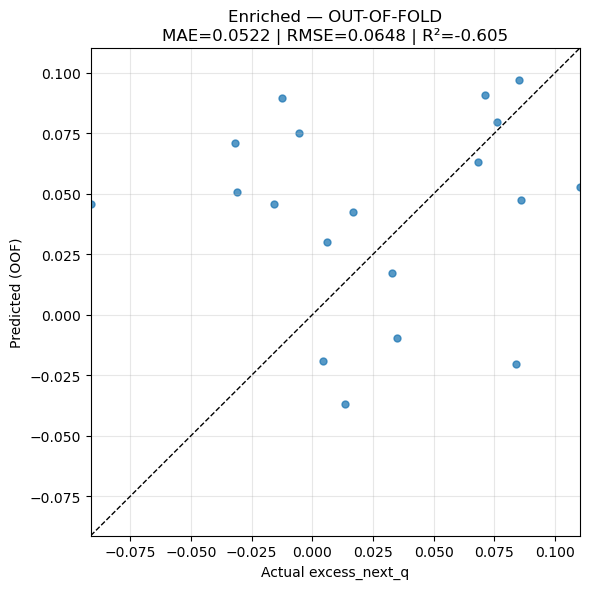

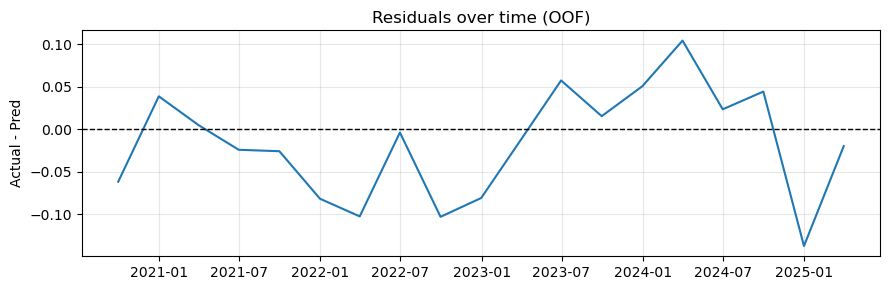

Saved OOF preds: C:\Users\abpanick\OneDrive - Microsoft\Documents\GitHub\marketpredict\processed\rq1_oof_predictions.csv


In [32]:
# =========================
# 16) OOF diagnostics and save predictions
# =========================
# Ensure chronological order
X_diag = X_en.sort_index()
y_diag = y.sort_index()

# Collect OOF preds across folds
splits_oof = make_expanding_splits(len(y_diag), min_train=24, test_size=2, step=1)
oof = pd.Series(index=y_diag.index, dtype=float, name="y_pred_en")

for tr_pos, te_pos in splits_oof:
    idx_tr, idx_te = X_diag.index[tr_pos], X_diag.index[te_pos]
    mdl = make_lgbm().fit(X_diag.loc[idx_tr], y_diag.loc[idx_tr])
    oof.loc[idx_te] = mdl.predict(X_diag.loc[idx_te])

oof = oof.dropna()
y_oof = y_diag.loc[oof.index]

# Metrics
mae  = mean_absolute_error(y_oof, oof)
rmse = mean_squared_error(y_oof, oof, squared=False)
r2   = r2_score(y_oof, oof)

# Scatter with 45° line
plt.figure(figsize=(6,6))
plt.scatter(y_oof, oof, s=25, alpha=0.75)
lims = [float(min(y_oof.min(), oof.min())), float(max(y_oof.max(), oof.max()))]
plt.plot(lims, lims, linestyle="--", color="black", linewidth=1)
plt.xlim(lims); plt.ylim(lims)
plt.title(f"Enriched — OUT-OF-FOLD\nMAE={mae:.4f} | RMSE={rmse:.4f} | R²={r2:.3f}")
plt.xlabel("Actual excess_next_q"); plt.ylabel("Predicted (OOF)")
plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

# Residuals over time
res = y_oof - oof
plt.figure(figsize=(9,3))
plt.plot(res.index, res.values)
plt.axhline(0, ls="--", lw=1, color="black")
plt.title("Residuals over time (OOF)")
plt.ylabel("Actual - Pred"); plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()

# Save OOF predictions
oof_out = pd.DataFrame({"y_true": y_oof, "y_pred_en": oof})
oof_out.to_csv(PROC/"rq1_oof_predictions.csv")
print("Saved OOF preds:", (PROC/"rq1_oof_predictions.csv").resolve())